In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import os
from typing import Dict
import pickle
from scipy.stats import linregress


def set_default_plot_style():
    plt.style.use("default")  # start clean

    plt.rcParams["axes.grid"] = True
    plt.rcParams["grid.alpha"] = 0.2
    plt.rcParams["grid.linestyle"] = "-"
    plt.rcParams["grid.color"] = "gray"

    plt.rcParams["axes.spines.top"] = False
    plt.rcParams["axes.spines.right"] = False

    plt.rcParams["axes.linewidth"] = 1.2

    plt.rcParams["legend.frameon"] = False

    plt.rcParams["font.size"] = 16
    plt.rcParams["axes.labelsize"] = 24
    plt.rcParams["legend.fontsize"] = 18

    mpl.rcParams['text.usetex'] = True
    mpl.rcParams['font.family'] = 'serif'
    mpl.rcParams['font.serif'] = ['Computer Modern Roman']

# Call once at the top of your script
set_default_plot_style()


In [8]:
# Helpful funcs
def log_b(x, b):
    return np.log(x) / np.log(b)


In [9]:
L_vals = [20_000]

epsilon_prime_c = 0.287808
epsilon_prime_vals = [epsilon_prime_c - 0.0002, epsilon_prime_c - 0.0001, epsilon_prime_c, epsilon_prime_c + 0.0001, epsilon_prime_c + 0.0002]
epsilon_prime_vals = [round(ep, ndigits=6) for ep in epsilon_prime_vals]

time_prefact = 100

num_initial_conds = 2000
initial_state_prob = 0.5

delta_vals = [0.1]

time_step = 10


cmap = plt.colormaps.get_cmap("Oranges").resampled(len(epsilon_prime_vals) + 5)


In [ ]:
# If first time

collected_rhos = {}
collected_rho_stds = {}

for L_val in L_vals:
    print(f"L_val: {L_val}")

    T_f = L_val*time_prefact
    collected_rhos[L_val] = {}
    collected_rho_stds[L_val] = {}

    for delta_val in delta_vals:
        print(f"L_val: {L_val} | delta: {delta_val}")
        delta_val_name = f"{delta_val}".replace(".", "p")

        collected_rhos[L_val][delta_val] = {}
        collected_rho_stds[L_val][delta_val] = {}

        for epsilon_prime in epsilon_prime_vals:
            print(f"L_val: {L_val} | delta: {delta_val} | epsilon: {epsilon_prime}")
            epsilon_val_name = f"{epsilon_prime}".replace(".", "p")

            current_rhos = np.array([[0.0 for _ in range(L_val * time_prefact // time_step)] for _ in range(num_initial_conds)])
            for init_cond in range(1, num_initial_conds+1):
                sample_filepath_name = f"data/time_rand_delta/rho_per_time/IC1/L{L_val}/delta{delta_val_name}/IC1_L{L_val}_epsilon{epsilon_val_name}_timepref{time_prefact}_sample{init_cond}.csv"
                df = pd.read_csv(sample_filepath_name)

                current_rhos[init_cond-1] = df.rho
            
            collected_rhos[L_val][delta_val][epsilon_prime] = np.mean(current_rhos.T, axis=1)
            collected_rho_stds[L_val][delta_val][epsilon_prime] = np.std(current_rhos.T, axis=1)

            pickle_path = f"data/time_rand_delta/rho_per_time/IC{num_initial_conds}/L{L_val}/delta{delta_val_name}/IC{num_initial_conds}_L{L_val}_epsilon{epsilon_val_name}_timepref{time_prefact}"
            dir_path = os.path.dirname(pickle_path)
            os.makedirs(dir_path, exist_ok=True)
            
            with open(pickle_path + "mean.pickle", "wb") as f:
                pickle.dump(collected_rhos[L_val][delta_val][epsilon_prime], f)
            with open(pickle_path + "stds.pickle", "wb") as f:
                pickle.dump(collected_rho_stds[L_val][delta_val][epsilon_prime], f)

## If you have already processed and saved the data as pickled

In [10]:

collected_rhos = {}
collected_rho_stds = {}

for L_val in L_vals:
    print(f"L_val: {L_val}")

    T_f = L_val*time_prefact
    collected_rhos[L_val] = {}
    collected_rho_stds[L_val] = {}

    for delta_val in delta_vals:
        print(f"L_val: {L_val} | delta: {delta_val}")
        delta_val_name = f"{delta_val}".replace(".", "p")

        collected_rhos[L_val][delta_val] = {}
        collected_rho_stds[L_val][delta_val] = {}
        for epsilon_prime in epsilon_prime_vals:
            epsilon_val_name = f"{epsilon_prime}".replace(".", "p")
            pickle_path = f"data/time_rand_delta/rho_per_time/IC{num_initial_conds}/L{L_val}/delta{delta_val_name}/IC{num_initial_conds}_L{L_val}_epsilon{epsilon_val_name}_timepref{time_prefact}"
            
            with open(pickle_path + "mean.pickle", "rb") as f:
                collected_rhos[L_val][delta_val][epsilon_prime] = pickle.load(f)
            with open(pickle_path + "stds.pickle", "rb") as f:
                collected_rho_stds[L_val][delta_val][epsilon_prime] = pickle.load(f)

L_val: 20000
L_val: 20000 | delta: 0.1


In [11]:
collected_rhos[L_vals[0]][delta_vals[0]][epsilon_prime_vals[0]] == collected_rhos[L_vals[0]][delta_vals[0]][epsilon_prime_vals[1]]

array([False, False, False, ..., False, False, False], shape=(200000,))

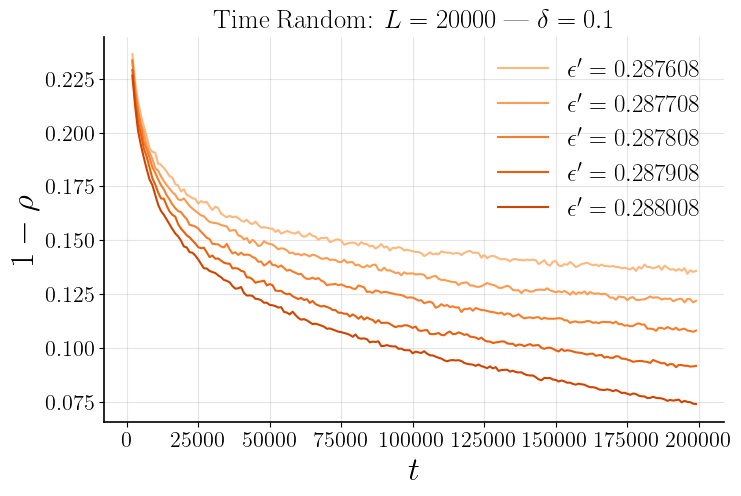

In [13]:
plt.figure(figsize=(8,5))

for j, L in enumerate(L_vals):
    for delta_val in delta_vals:
        delta_val_name = f"{delta_val}".replace(".", "p")
        for i, epsilon_val in enumerate(epsilon_prime_vals):
            c = cmap(i+3)
            time_vals = [i * time_step for i in range(0, L*time_prefact // time_step)]
            plt.plot(
                time_vals[200:20000:100], 
                1-collected_rhos[L][delta_val][epsilon_val][200:20000:100], 
                label = fr"$\epsilon' = {epsilon_val}$",
                # fmt='--',  
                # markersize=3,
                # marker = "o",
                # capsize=3,
                c=c
                )
        # plt.axvline(0.29450750, c = 'k', label=f"x = 0.29450750 (old trans)")
        plt.title(fr"Time Random: $L = {L}$ | $\delta = {delta_val}$")
        plt.xlabel(r"$t$")
        plt.ylabel(r"$1 - \rho$")
        plt.legend()

        plt.show()


/var/folders/0k/n4x5z88x1rx124p1g1l55hmc0000gn/T/ipykernel_94999/1739338123.py:9: RuntimeWarning: divide by zero encountered in log
  log_time_vals = np.log(np.array(time_vals))


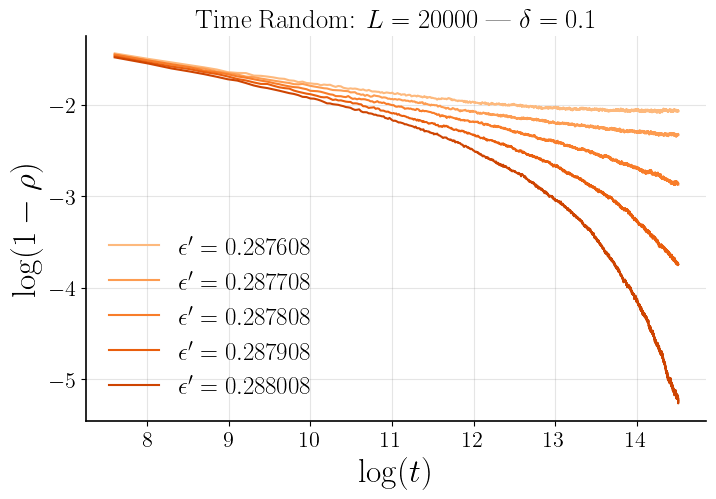

In [15]:
plt.figure(figsize=(8,5))

for j, L in enumerate(L_vals):
    for delta_val in delta_vals:
        delta_val_name = f"{delta_val}".replace(".", "p")
        for i, epsilon_val in enumerate(epsilon_prime_vals):
            c = cmap(i+3)
            time_vals = [i * time_step for i in range(0, L*time_prefact // time_step)]
            log_time_vals = np.log(np.array(time_vals))
            data_to_plot = np.log(1-collected_rhos[L][delta_val][epsilon_val])
            plt.plot(
                log_time_vals[200::100], 
                data_to_plot[200::100], 
                label = fr"$\epsilon' = {round(epsilon_val, ndigits=7)}$",
                # fmt='--',  
                # markersize=3,
                # marker = "o",
                # capsize=3,
                c=c
                )
        # plt.axvline(0.29450750, c = 'k', label=f"x = 0.29450750 (old trans)")
        plt.title(fr"Time Random: $L = {L}$ | $\delta = {delta_val}$")
        plt.xlabel(r"$\log(t)$")
        plt.ylabel(r"$\log(1 - \rho)$")
        plt.legend()

        plt.show()


In [16]:
# Calculate the slopes
curve_fit_data = {}

for j, L in enumerate(L_vals):
    curve_fit_data[L] = {}
    for delta_val in delta_vals:
        delta_val_name = f"{delta_val}".replace(".", "p")
        curve_fit_data[L][delta_val] = {}
        for i, epsilon_val in enumerate(epsilon_prime_vals):
            time_vals = [i * time_step for i in range(0, L*time_prefact // time_step)]
            log_time_vals = np.log(np.array(time_vals))
            data = np.log(1-collected_rhos[L][delta_val][epsilon_val])

            result = linregress(log_time_vals[200::100], data[200::100])
            curve_fit_data[L][delta_val][epsilon_val] = result
            print(f"L: {L} | Delta: {delta_val} | epsilon: {epsilon_val} | delta: {-result.slope} | slope_err: {result.stderr}")

L: 20000 | Delta: 0.1 | epsilon: 0.287608 | delta: 0.05560117191494908 | slope_err: 0.0005693664284625959
L: 20000 | Delta: 0.1 | epsilon: 0.287708 | delta: 0.11344187081023115 | slope_err: 0.0003319833043538816
L: 20000 | Delta: 0.1 | epsilon: 0.287808 | delta: 0.24345664194561384 | slope_err: 0.0008708417977511331
L: 20000 | Delta: 0.1 | epsilon: 0.287908 | delta: 0.45850355269496373 | slope_err: 0.00330043281855705
L: 20000 | Delta: 0.1 | epsilon: 0.288008 | delta: 0.8264294156881042 | slope_err: 0.007985476536368821


/var/folders/0k/n4x5z88x1rx124p1g1l55hmc0000gn/T/ipykernel_94999/3237280329.py:11: RuntimeWarning: divide by zero encountered in log
  log_time_vals = np.log(np.array(time_vals))


/var/folders/0k/n4x5z88x1rx124p1g1l55hmc0000gn/T/ipykernel_94999/2215233772.py:9: RuntimeWarning: divide by zero encountered in log
  log_time_vals = np.log(np.array(time_vals))


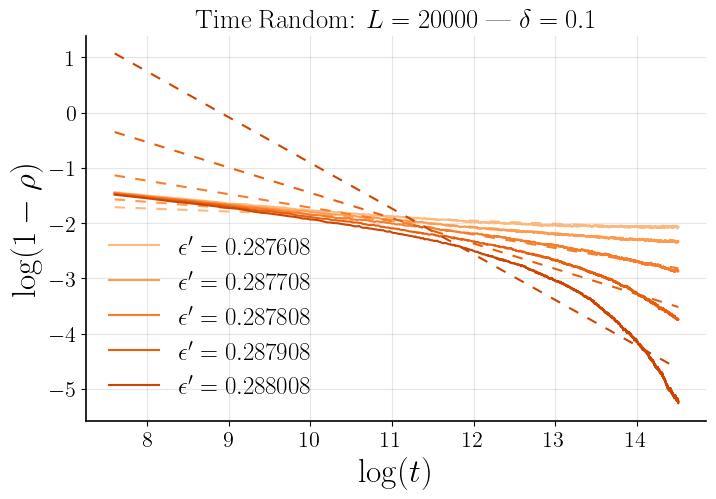

In [17]:
plt.figure(figsize=(8,5))

for j, L in enumerate(L_vals):
    for delta_val in delta_vals:
        delta_val_name = f"{delta_val}".replace(".", "p")
        for i, epsilon_val in enumerate(epsilon_prime_vals):
            c = cmap(i+3)
            time_vals = [i * time_step for i in range(0, L*time_prefact // time_step)]
            log_time_vals = np.log(np.array(time_vals))
            data_to_plot = np.log(1-collected_rhos[L][delta_val][epsilon_val])
            plt.plot(
                log_time_vals[200::100], 
                data_to_plot[200::100], 
                label = fr"$\epsilon' = {round(epsilon_val, ndigits=7)}$",
                # fmt='--',  
                # markersize=3,
                # marker = "o",
                # capsize=3,
                c=c
                )
            
            line_fit_result = curve_fit_data[L][delta_val][epsilon_val]
            plt.plot(
                log_time_vals[200::100],
                log_time_vals[200::100] * line_fit_result.slope + line_fit_result.intercept,
                c=c,
                linestyle = "--",
                dashes=(5, 5)
            )

        # plt.axvline(0.29450750, c = 'k', label=f"x = 0.29450750 (old trans)")
        plt.title(fr"Time Random: $L = {L}$ | $\delta = {delta_val}$")
        plt.xlabel(r"$\log(t)$")
        plt.ylabel(r"$\log(1 - \rho)$")
        plt.legend()

        plt.show()

/var/folders/0k/n4x5z88x1rx124p1g1l55hmc0000gn/T/ipykernel_94999/419355219.py:15: RuntimeWarning: divide by zero encountered in divide
  np.log((1/np.array(time_vals))[1:]),


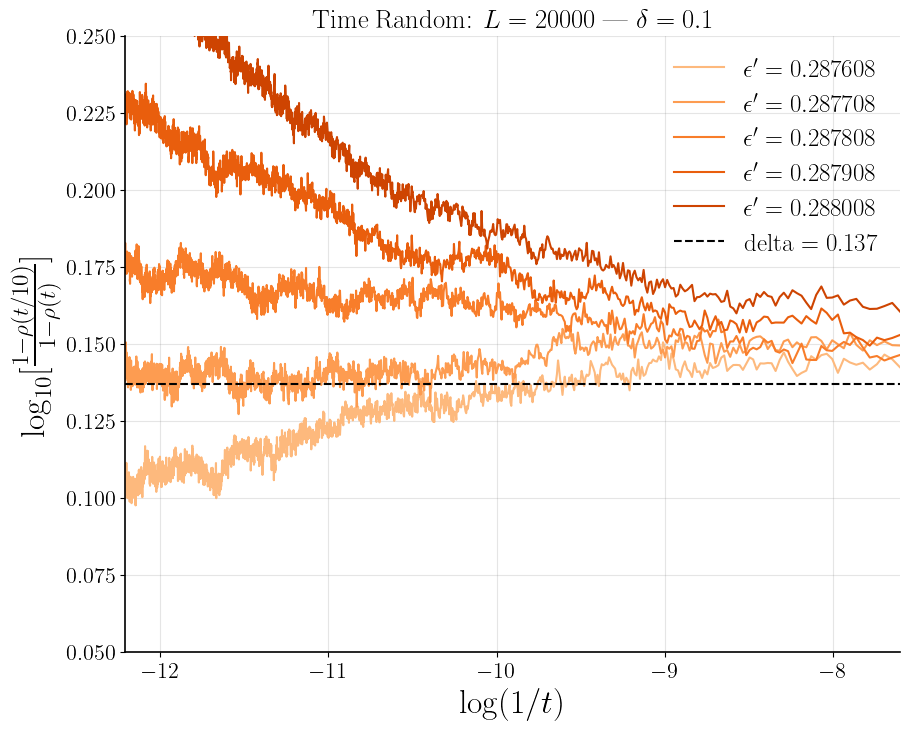

In [18]:
b = 10
plt.figure(figsize=(10,8))
for j, L in enumerate(L_vals):
    for delta_val in delta_vals:
        delta_val_name = f"{delta_val}".replace(".", "p")
        for i, epsilon_val in enumerate(epsilon_prime_vals):
            c = cmap(i+3)
            time_vals = [i * time_step*time_step for i in range(0, L*time_prefact // (time_step * time_step))]
            data_to_plot = 1-collected_rhos[L][delta_val][epsilon_val]
            data_to_plot_numerator = np.array([data_to_plot[(i*time_step)//b] for i in range(0, len(data_to_plot))])
            data_to_plot_denomenator = np.array([data_to_plot[i*b] for i in range(0, len(data_to_plot)//(b))])
            data_to_plot = log_b(data_to_plot_numerator[:len(data_to_plot_denomenator)]/data_to_plot_denomenator, 10)
            time_vals = [i * time_step * b for i in range(0, L*time_prefact // (time_step * time_step))]
            plt.plot(
                np.log((1/np.array(time_vals))[1:]), 
                data_to_plot[1:], 
                label = fr"$\epsilon' = {epsilon_val}$",
                # fmt='--',  
                # markersize=3,
                # marker = "o",
                # capsize=3,
                c=c
                )
        
        delta_guess = 0.137
        plt.axhline(delta_guess, c = 'k', label=f"delta = {delta_guess}", linestyle ="--")
        plt.title(fr"Time Random: $L = {L}$ | $\delta = {delta_val}$")
        plt.xlabel(r"$\log(1/t)$")
        plt.ylabel(r"$\log_{10}[\frac{1-\rho(t/10)}{1-\rho(t)}]$")
        plt.legend()
        plt.xlim((np.log(0.000005), np.log(0.0005)))
        plt.ylim((0.05, 0.25))

        plt.show()

# By hand collpase
The expected form (near the crit pt) is

$(1-\rho)t^{\beta/\nu_{\|}} \sim g(t^{-z})$